<a href="https://colab.research.google.com/github/poladudek/nyc-crime-map/blob/main/Wiz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geodatasets
!pip install geoplot

In [ ]:
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import geoplot as gplt
import numpy as np
import matplotlib.pyplot as plt
import bokeh.io as bh
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, VBar, Plot
from bokeh.plotting import figure, show
from shapely.geometry import Point

In [ ]:
drug_crimes_api = "https://data.cityofnewyork.us/resource/v35q-aj2k.csv"
drug_crimes = pd.read_csv(drug_crimes_api)
drug_crimes.head()

cmplnt_num             cmplnt_fr_dt cmplnt_fr_tm             cmplnt_to_dt  \
0    46380100  2008-05-11T00:00:00.000     16:40:00  2008-05-11T00:00:00.000   
1    45634724  2008-04-11T00:00:00.000     18:22:00                      NaN   
2    51116638  2008-09-07T00:00:00.000     22:30:00  2008-09-07T00:00:00.000   
3    45349325  2008-04-09T00:00:00.000     12:13:00                      NaN   
4    47409581  2008-06-20T00:00:00.000     20:25:00  2008-06-20T00:00:00.000   

  cmplnt_to_tm  addr_pct_cd                   rpt_dt  ky_cd        ofns_desc  \
0     16:53:00           77  2008-05-11T00:00:00.000    117  DANGEROUS DRUGS   
1       (null)           40  2008-04-11T00:00:00.000    117  DANGEROUS DRUGS   
2     22:39:00           77  2008-09-07T00:00:00.000    235  DANGEROUS DRUGS   
3       (null)           32  2008-04-09T00:00:00.000    235  DANGEROUS DRUGS   
4     20:40:00           23  2008-06-20T00:00:00.000    235  DANGEROUS DRUGS   

   pd_cd  ... loc_of_occur_desc               prem_typ_desc  \
0    500  ...          FRONT OF                      STREET   
1    501  ...            (null)                      STREET   
2    567  ...          FRONT OF                      STREET   
3    567  ...          FRONT OF                      STREET   
4    567  ...            INSIDE  RESIDENCE - PUBLIC HOUSING   

            juris_desc parks_nm hadevelopt x_coord_cd y_coord_cd   latitude  \
0     N.Y. POLICE DEPT   (null)     (null)     997760     186202  40.677748   
1     N.Y. POLICE DEPT   (null)     (null)    1007925     234995  40.811651   
2     N.Y. POLICE DEPT   (null)     (null)     999901     183190  40.669480   
3     N.Y. POLICE DEPT   (null)     (null)     999666     234161  40.809382   
4  N.Y. HOUSING POLICE   (null)     (null)    1000086     229653  40.797008   

   longitude                         lat_lon  
0 -73.951291    POINT (-73.951291 40.677748)  
1 -73.914474  POINT (-73.914474 40.81165101)  
2 -73.943580      POINT (-73.94358 40.66948)  
3 -73.944311    POINT (-73.944311 40.809382)  
4 -73.942802    POINT (-73.942802 40.797008)  

[5 rows x 24 columns]

In [ ]:
drug_crimes.dtypes

cmplnt_num             int64
cmplnt_fr_dt          object
cmplnt_fr_tm          object
cmplnt_to_dt          object
cmplnt_to_tm          object
addr_pct_cd            int64
rpt_dt                object
ky_cd                  int64
ofns_desc             object
pd_cd                  int64
pd_desc               object
crm_atpt_cptd_cd      object
law_cat_cd            object
boro_nm               object
loc_of_occur_desc     object
prem_typ_desc         object
juris_desc            object
parks_nm              object
hadevelopt            object
x_coord_cd             int64
y_coord_cd             int64
latitude             float64
longitude            float64
lat_lon               object
dtype: object

In [ ]:
# Potrzebujemy latitude oraz longitude bezwarunkowo aby ustalić, do której dzielnicy należy przesępstwo
# podobnie poziom przestępstwa i czas aby można było przeprowadzić głębszą analizę

drug_crimes_cleared = drug_crimes.dropna(subset=["latitude", "longitude", "ofns_desc"])
drug_crimes_cleared["ofns_desc"] = drug_crimes_cleared["ofns_desc"].astype(str)

In [ ]:
path_to_file = get_path('nybb')
districts = gpd.read_file(path_to_file)
# districts.plot()
districts.head()

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

In [ ]:
print(type(drug_crimes_cleared['lat_lon'].iloc[0]))

<class 'str'>


In [ ]:
geo_crimes = drug_crimes_cleared.copy()
geo_crimes['geometry'] = geo_crimes.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_crimes = gpd.GeoDataFrame(geo_crimes, geometry='geometry', crs='EPSG:4326')


In [ ]:
districts = districts.to_crs(geo_crimes.crs)

geo_crimes_with_borough = gpd.sjoin(
    geo_crimes,
    districts[['BoroName', 'geometry']],
    how='left',
    predicate='within'
)

geo_crimes_with_borough.head()

cmplnt_num             cmplnt_fr_dt cmplnt_fr_tm             cmplnt_to_dt  \
0    46380100  2008-05-11T00:00:00.000     16:40:00  2008-05-11T00:00:00.000   
1    45634724  2008-04-11T00:00:00.000     18:22:00                      NaN   
2    51116638  2008-09-07T00:00:00.000     22:30:00  2008-09-07T00:00:00.000   
3    45349325  2008-04-09T00:00:00.000     12:13:00                      NaN   
4    47409581  2008-06-20T00:00:00.000     20:25:00  2008-06-20T00:00:00.000   

  cmplnt_to_tm  addr_pct_cd                   rpt_dt  ky_cd        ofns_desc  \
0     16:53:00           77  2008-05-11T00:00:00.000    117  DANGEROUS DRUGS   
1       (null)           40  2008-04-11T00:00:00.000    117  DANGEROUS DRUGS   
2     22:39:00           77  2008-09-07T00:00:00.000    235  DANGEROUS DRUGS   
3       (null)           32  2008-04-09T00:00:00.000    235  DANGEROUS DRUGS   
4     20:40:00           23  2008-06-20T00:00:00.000    235  DANGEROUS DRUGS   

   pd_cd  ... parks_nm hadevelopt x_coord_cd y_coord_cd   latitude  longitude  \
0    500  ...   (null)     (null)     997760     186202  40.677748 -73.951291   
1    501  ...   (null)     (null)    1007925     234995  40.811651 -73.914474   
2    567  ...   (null)     (null)     999901     183190  40.669480 -73.943580   
3    567  ...   (null)     (null)     999666     234161  40.809382 -73.944311   
4    567  ...   (null)     (null)    1000086     229653  40.797008 -73.942802   

                          lat_lon                    geometry index_right  \
0    POINT (-73.951291 40.677748)  POINT (-73.95129 40.67775)           2   
1  POINT (-73.914474 40.81165101)  POINT (-73.91447 40.81165)           4   
2      POINT (-73.94358 40.66948)  POINT (-73.94358 40.66948)           2   
3    POINT (-73.944311 40.809382)  POINT (-73.94431 40.80938)           3   
4    POINT (-73.942802 40.797008)   POINT (-73.9428 40.79701)           3   

    BoroName  
0   Brooklyn  
1      Bronx  
2   Brooklyn  
3  Manhattan  
4  Manhattan  

[5 rows x 27 columns]

In [ ]:
counted_drug_crimes = geo_crimes_with_borough['BoroName'].value_counts()
print(counted_drug_crimes)

BoroName
Manhattan    390
Brooklyn     357
Bronx        242
Queens        11
Name: count, dtype: int64


In [ ]:
districts['count'] = districts['BoroName'].map(counted_drug_crimes)
districts['count'] = districts['count'].replace(np.nan, 0)
districts['count'] = districts['count'].astype(int)
districts.head()

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  count  
0  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...      0  
1  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...     11  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...    357  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...    390  
4  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...    242

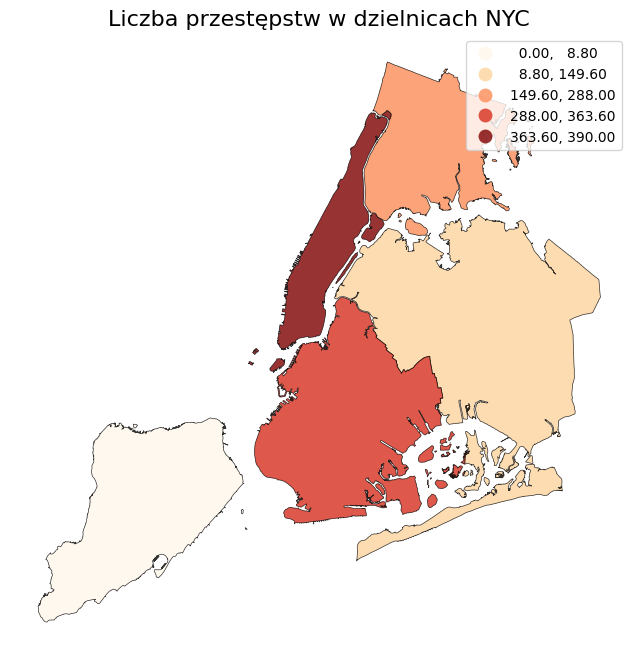

In [ ]:
#districts = districts.explode(index_parts=False) # rozdziela mulipoligony na poligony np. wyspy na Manhattanie pandasgeo nie potrzrbuje
fig, ax = plt.subplots(figsize=(12, 8))

districts.plot(
    column='count',
    cmap='OrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    scheme='quantiles',
    k=5,
    ax=ax
)

ax.set_title('Liczba przestępstw w dzielnicach NYC', fontsize=16)
ax.set_axis_off()
plt.show()

In [ ]:
count_df = counted_drug_crimes.reset_index()
output_notebook()
from bokeh.palettes import OrRd


colors = OrRd[4]
count_df['color'] = colors
source_drugs = ColumnDataSource(count_df)

plot_drug_count = figure(x_range = count_df["BoroName"].tolist(), title = "Liczba przestępstw w dzielnicach NYC")
plot_drug_count.vbar(x = "BoroName", top = "count", source = source_drugs, fill_color='color', line_color='black')
show(plot_drug_count)


In [ ]:
# todo: drugie zrodlo zeby dodac i skombinowac jako jedna calosc